In [43]:
# t - test analysis to find significant features of a specific road segment (or municipality) compared to all other road segments (or municipalities).
# output is list of streets / roads / road segments and their outstanding values


import pandas as pd
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
import seaborn as sns


sample_size = 100000 # choose 1000 to reduce runtime
raw_data = pd.read_csv("C://Users//user//PycharmProjects//anyway//data//views_2019//involved_markers_hebrew.csv",nrows=sample_size,low_memory=False)

In [44]:
# get list of top X groups of category Y (top 20 yishiuvim)
def get_top(number,category):
    top_list= raw_data.groupby(category).size().reset_index().rename(columns={0: "count"}).sort_values(by='count',ascending=False)
    return top_list.head(number)[category]

#segments to analyze (everything is optional, remove segments that create unuseful output
demographic_segments = [
    'is_over_70',
    'is_under_14',
   # 'is_pedestrian'
   # ,'is_jew'
]
accident_segments = [
  #  'is_daytime',
   # 'is_weekend',
    'is_head-on',
    'is_roll-over',
    'is_hard',
    'is_deadly',
    'is_animal',
    'is_truck',
    'is_electric'
    
]



In [48]:
#data cleaning 
def clean_data(data,category):
    data['is_male'] = data['sex'].replace(0,np.nan).replace(2,0) #male = 1, female = 0, remove unknown
    data['is_over_70'] = data['age_group'].replace(99,np.nan) #remove unknown
    data['is_over_70'] = np.where(data['is_over_70']>14,1,0) #above code 14 is over 70
    data['is_under_14'] = data['age_group'].replace(99,np.nan) #remove unknown
    data['is_under_14'] = np.where(data['is_under_14']<4,1,0) #under code 4 is over 14
    data['is_weekend'] = np.where(data['day_in_week']>5,1,0) #Fri and Sat are weekends
    data['is_jew'] = data['population_type'].replace([2,3,4,''],0)#convert non jews to 0
    data['is_daytime'] = data['day_night'].replace(5,0)#convert night (5) to 0
    data['is_pedestrian'] = data['injured_type'].replace([2,3,4,5,6,7,8,9],0) #convert non pedestrian to 0, pedestrian to 1
    data['is_summer'] = data['accident_month'].replace([10,11,12,1,2,3],0).replace([4,5,6,7,8,9],1) #convert winter to 0 ,summer to 1
    data['is_head-on'] = np.where(data['accident_type']==5,1,0) # type 5 is headon (TEUNA HAZITIT)
    data['is_animal'] = np.where(data['accident_type']==19,1,0) # type 19 is animal crash
    data['is_hard'] = data['accident_severity'].replace(3,0).replace([1,2],1) # hard accidents will get 1
    data['is_deadly'] = data['accident_severity'].replace([3,2],0)# deadly accidents will get 1
    data['is_driver'] = data['injured_type'].replace([2,3,4,5,6,7,8,9],0) #convert non drivers to 0, drivers to 1
    data['is_roll-over'] = np.where(data['accident_type']==10,1,0)# type 10 is roll-over
    data['is_motorcycle'] = np.where((data['vehicle_vehicle_type']>7) & (data['vehicle_vehicle_type']<11),1,0) # numbers that represent motorcycle
    data['is_truck'] = np.where((data['vehicle_vehicle_type']>3) & (data['vehicle_vehicle_type']<8),1,0) # numbers that represent truck
    data['is_electric'] = np.where((data['vehicle_vehicle_type']>20) & (data['vehicle_vehicle_type']<24),1,0) # numbers that represent truck
   
    data['full_street1_hebrew'] = data['accident_yishuv_name'] +"_" + data['street1_hebrew'] # new column of city+street name
    
    data = data[data[category].notnull()] # filter for not null of input type (type of place)
    
    data = data[data['involved_type'] != 1] # only NIFGAIM, not drivers
    
    data = data[data['accident_year'] >2008] # play with the dates
    
    #set real values for the binary values in segments
    
    value_dict = {} 
    value_dict['is_male'] = ('נקבה','זכר')
    value_dict['is_over_70'] = ('מתחת_70','מעל_70')
    value_dict['is_under_14'] = ('מעל_14','מתחת_14')
    value_dict['is_weekend'] = ('ימי_השבוע','סוף_שבוע')
    value_dict['is_jew'] = ('לא_יהודי','יהודי')
    value_dict['is_daytime'] = ('שעות_הלילה','שעות_היום')
    value_dict['is_pedestrian'] = ('לא_הולך_רגל','הולך_רגל')
    value_dict['is_summer'] = ('חורף','קיץ')
    value_dict['is_head-on'] = ('לא_התנגשות_חזיתית','התנגשות_חזיתית')
    value_dict['is_roll-over'] = ('לא_התהפכות','התהפכות')
    value_dict['is_hard'] = ('פגיעה_קלה','פגיעה_קשה')
    value_dict['is_deadly'] = ('תאונה_לא_קטלנית','תאונה_קטלנית')
    value_dict['is_driver'] = ('לא_נהג','נהג')
    value_dict['is_animal'] = ('לא_פגיעה_בבעל_חיים','פגיעה_בבעל_חיים')
    value_dict['is_motorcycle'] = ('לא_אופנוע','אופנוע')
    value_dict['is_truck'] = ('לא_משאית','משאית')
    value_dict['is_electric'] = ('לא_דו_גלגלי_חשמלי','דו_גלגלי_חשמלי')
    
    #if category is intercity - compare only to intercity accidents, if its innercity - compare to innercity
    
    if category == 'road_segment_name':
        data = data[data['road_type_hebrew'].isin(['לא-עירונית לא בצומת','לא-עירונית בצומת'])] 
    if category == 'accident_yishuv_name':
        data = data[data['road_type_hebrew'].isin(['עירונית לא בצומת','עירונית בצומת'])]
    if category == 'full_street1_hebrew':
        data = data[data['road_type_hebrew'].isin(['עירונית לא בצומת','עירונית בצומת'])]
    if category == 'road1':
        data = data[data['road_type_hebrew'].isin(['לא-עירונית לא בצומת','לא-עירונית בצומת'])] 
        
    # create data table that contains only unique accidents - for analysing accident segments
    
    data_unique = data.drop_duplicates(subset ="provider_and_id") 
    
    print("Shape of Accidents Table:\n ",data_unique.shape)
    print("Shape of Involved Table:\n ",data.shape)
    
    return data,data_unique,value_dict
    





In [49]:
# function for analysing segments
def analyse_segment(data,segment,location,category):
    result = []
    filtered_data = data[data[category]==location] #table of only the value chosen (MIKTA X for example)
    all_rows = data[segment].dropna().reset_index(drop=True) #only the segment column
    filtered_rows = filtered_data[segment].dropna() #only the segment column  - filtered data
    s,p = ttest_ind(all_rows,filtered_rows,nan_policy='omit') # ttest for the segment columns
    if p > 0.1 or np.isnan(p):
        return result
    percent_filtered = 'percent_of_filtered' #create column name for percent in segmented data
    count_filtered = "count_of_filtered"#create column name for count in segmented data
    acc_data_tmp = data.groupby(segment).size().reset_index().rename(columns={0: "count"}) #create groupby table
    acc_data_tmp['percent'] = acc_data_tmp["count"]/acc_data_tmp["count"].sum() # create percent column
    acc_data_tmp['percent'] = acc_data_tmp['percent'].astype(float).map(lambda n: '{:.0%}'.format(n)) #convert to percent format
    filtered_acc_data_tmp =  filtered_data.groupby(segment).size().reset_index().rename(columns={0: count_filtered})
    filtered_acc_data_tmp[percent_filtered] = \
        filtered_acc_data_tmp[count_filtered]/filtered_acc_data_tmp[count_filtered].sum()
    filtered_acc_data_tmp[percent_filtered] = filtered_acc_data_tmp[percent_filtered].astype(float).map(lambda n: '{:.0%}'.format(n))
    
    #create new table: rows: 0,1 (values of specific segment). columns: count of accidents, percent of accidents per total accidents and per filtered accidents
    final_table = pd.concat([acc_data_tmp, filtered_acc_data_tmp.drop(segment,axis = 1)], axis=1, sort=False)
    if final_table.isnull().values.any():
        return result
    for j in range(len(final_table)): # iterate over 0,1 of the segment to find the winning variable
        filtered_count = final_table.loc[j,count_filtered]
        filtered_count_other_variant = final_table.loc[1-j,count_filtered]
        original_count = final_table.loc[j,'count']
        original_count_other_variant = final_table.loc[1-j,'count']
        filtered_percent = float(final_table.loc[j,percent_filtered].strip('%'))/100
        original_percent = float(final_table.loc[j,'percent'].strip('%'))/100
        if original_percent == 0:
            return result
        if (filtered_percent - original_percent > 0.10 or filtered_percent/original_percent > 2) \
                and filtered_percent > 0.04 and filtered_count > 10: #if the difference is significant  - tell me
            significant_segment = value_dict[segment][j]
            percents = 'Number of accidents: {:d} = {:.0%} vs. {:.0%}'.format(filtered_count,filtered_percent,original_percent)
            result.append(significant_segment)
            result.append(percents)
            
            def make_autopct(values):
                def my_autopct(pct):
                    total = sum(values)
                    val = int(round(pct*total/100.0))
                    return '{v:d}'.format(v=val) #'{p:.0f}%  ({v:d})'p=pct,
                return my_autopct

            fig, (ax1, ax2) = plt.subplots(1, 2)
            
             # Data to plot 1
            labels = get_display(value_dict[segment][j]), get_display(value_dict[segment][1-j])
            sizes =[original_count,original_count_other_variant]
            colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
            explode = (0.1, 0)  # explode 1st slice
            
            # Plot
            ax1.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct=make_autopct(sizes), shadow=True, startangle=0)
            ax1.title.set_text('All data')
            
            # Data to plot 2
            sizes = [filtered_count,filtered_count_other_variant]
            colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
            explode = (0.1, 0)  # explode 1st slice
            
            # Plot
            ax2.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct=make_autopct(sizes), shadow=True, startangle=0)
            if isinstance(location,float):
                ax2.title.set_text(location)
            else:
                ax2.title.set_text(get_display(location))

            
            
            
            plt.axis('equal')
            #plt.show()
            
            return result
    

Shape of Accidents Table:
  (21454, 175)
Shape of Involved Table:
  (25822, 175)

********************************************************************************************************
Category: full_street1_hebrew
********************************************************************************************************


בת ים_שד יוספטל גיורא
['מעל_70', 'Number of accidents: 11 = 14% vs. 6%']


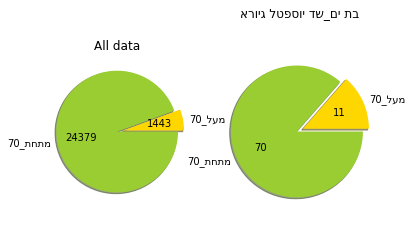

ירושלים_בית חנינה החדשה
['מתחת_14', 'Number of accidents: 17 = 27% vs. 9%']


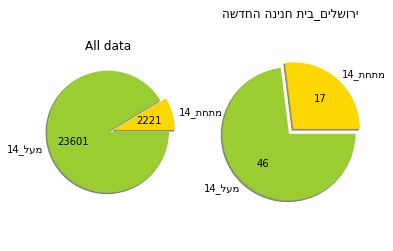

בת ים_בלפור
['מעל_70', 'Number of accidents: 12 = 24% vs. 6%']


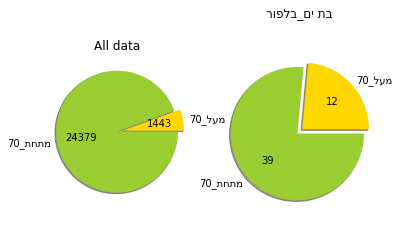

Shape of Accidents Table:
  (8841, 175)
Shape of Involved Table:
  (15710, 175)

********************************************************************************************************
Category: road_segment_name
********************************************************************************************************


צומת יבור - צומת חנא
['מתחת_14', 'Number of accidents: 35 = 24% vs. 9%']


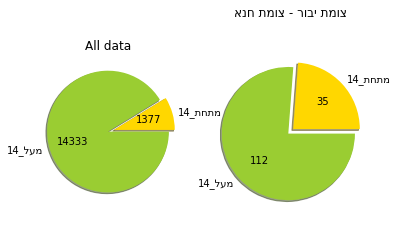

מחלף לקייה - צומת ערד
['פגיעה_קשה', 'Number of accidents: 11 = 18% vs. 7%']


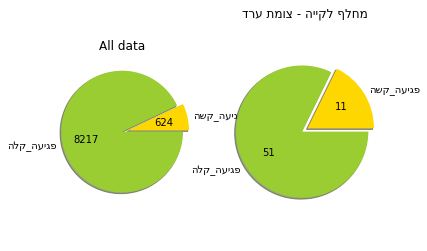

צומת מגידו - צומת התשבי (צפוני)
['מתחת_14', 'Number of accidents: 13 = 23% vs. 9%']


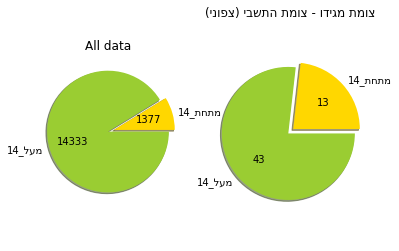

צומת רמה מזרח - צומת חנניה
['מתחת_14', 'Number of accidents: 11 = 19% vs. 9%']


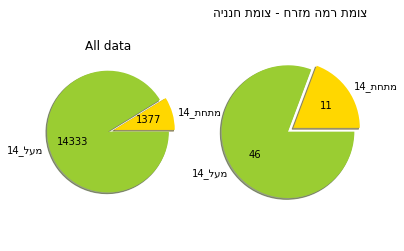

צומת שמשון - מחלף שער הגיא
['מתחת_14', 'Number of accidents: 13 = 31% vs. 9%']


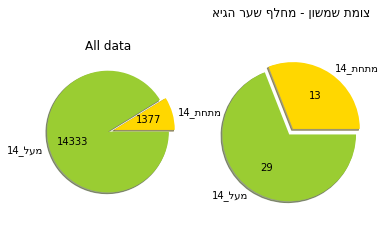

מחלף בית רימון - מחלף גולני
['מתחת_14', 'Number of accidents: 11 = 24% vs. 9%']


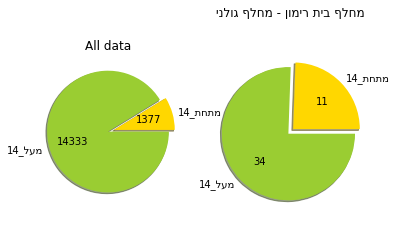

Shape of Accidents Table:
  (9708, 175)
Shape of Involved Table:
  (16874, 175)

********************************************************************************************************
Category: road1
********************************************************************************************************


6.0
['משאית', 'Number of accidents: 14 = 5% vs. 2%']


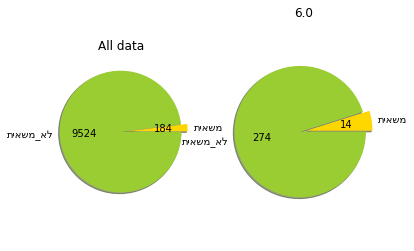

60.0
['התנגשות_חזיתית', 'Number of accidents: 38 = 13% vs. 5%']


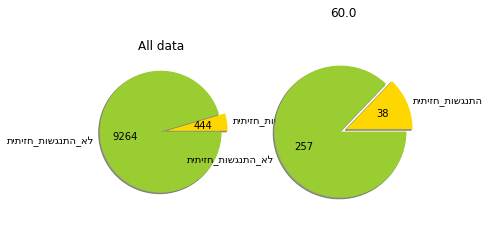

90.0
['התהפכות', 'Number of accidents: 18 = 9% vs. 2%']


['פגיעה_קשה', 'Number of accidents: 30 = 15% vs. 7%']


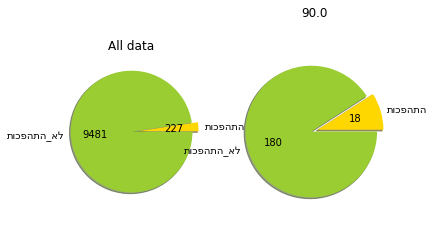

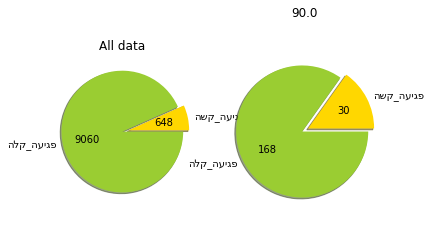

25.0
['התהפכות', 'Number of accidents: 12 = 8% vs. 2%']


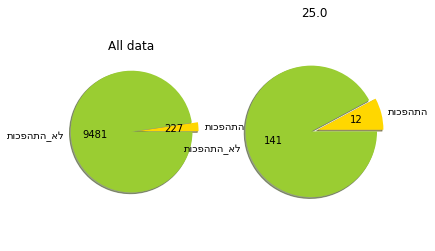

31.0
['מעל_70', 'Number of accidents: 16 = 9% vs. 3%']
['פגיעה_קשה', 'Number of accidents: 18 = 19% vs. 7%']


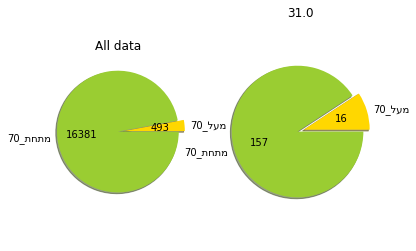

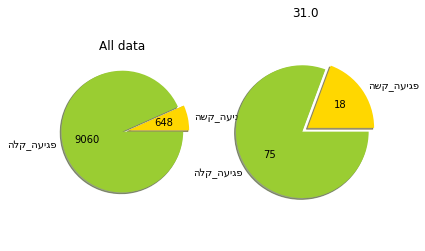

805.0
['מתחת_14', 'Number of accidents: 35 = 24% vs. 9%']


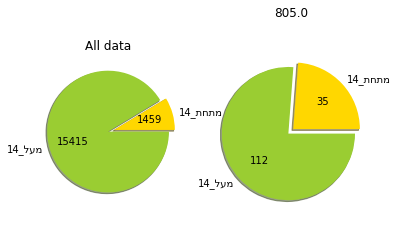

66.0
['מתחת_14', 'Number of accidents: 19 = 23% vs. 9%']


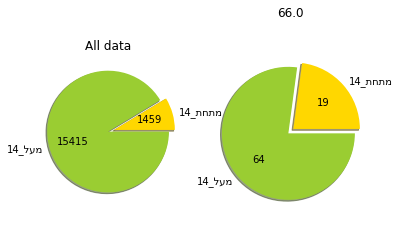

87.0
['מתחת_14', 'Number of accidents: 11 = 20% vs. 9%']


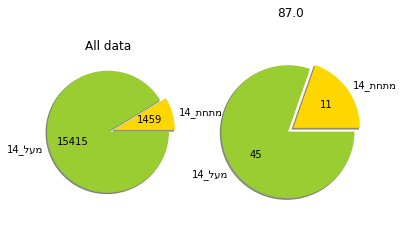

In [50]:
for category in ['full_street1_hebrew','road_segment_name','road1']:
    data,data_unique,value_dict = clean_data(raw_data,category)
    top_list = get_top(150,category)
    print("\n********************************************************************************************************")
    print("Category:",category)
    print("********************************************************************************************************")
    for i in top_list:
        list = []
        for j in demographic_segments:
            result = analyse_segment(data,j,i,category)
            if result:
                list.append(result)
        for j in accident_segments:
            result = analyse_segment(data_unique,j,i,category)
            if result:
                list.append(result)
        if list:
            print("==========================================================================================")
            print(i)
            print("==========================================================================================")
            for x in list:
                print (x)
            plt.show()
            